##### Load the dataset

###### Chúng tôi sẽ bắt đầu bằng cách tải tập dữ liệu chữ số. Tập dữ liệu này chứa các chữ số viết tay từ 0 đến 9. Trong bối cảnh phân cụm, người ta muốn nhóm các hình ảnh sao cho các chữ số viết tay trên ảnh giống nhau.

In [1]:
import numpy as np
from sklearn.datasets import load_digits # load dữ liệu chữ số

# Tải dữ liệu
data, labels = load_digits(return_X_y=True) 
"""
    'return_X_y': chỉ định rằng hàm này sẽ trả về một tuple chứa hai phần tử
        'data': Một mảng chứa các đặc trưng của dữ liệu.
        -> sẽ chứa các hình ảnh số hóa dưới dạng mảng phẳng 2D với mỗi hàng là một hình ảnh (64 đặc trưng đại diện cho 8x8 pixel).
        'labels': Một mảng chứa các nhãn tương ứng với các mẫu dữ liệu.
        -> sẽ chứa các nhãn số từ 0 đến 9 tương ứng với các hình ảnh.
"""

# Định nghĩa số mẫu và số đặc trưng:
(n_samples, n_features), n_digits = data.shape, np.unique(labels).size 
"""
    'data.shape' trả về một tuple chứa số mẫu và số đặc trưng của dữ liệu.
        'n_samples': Số lượng mẫu trong bộ dữ liệu.
        'n_features': Số lượng đặc trưng (64 pixel cho mỗi hình ảnh 8x8).

    'np.unique(labels).size' tính số lượng nhãn khác nhau trong labels, tương ứng với số chữ số (0-9), hay chính là số cụm trong dữ liệu chữ số này.
"""

print(f"# digits: {n_digits}; # samples: {n_samples}; # features {n_features}")

# digits: 10; # samples: 1797; # features 64


In [5]:
type(data)

numpy.ndarray

##### Define evaluation benchmark

###### Đầu tiên sẽ làm tiêu chuẩn đánh giá. Trong quá trình đo điểm chuẩn này, dự định so sánh các phương pháp khởi tạo khác nhau cho KMeans. Điểm chuẩn sẽ:  
- tạo một đường dẫn sẽ chia tỷ lệ dữ liệu bằng $StandardScaler$
- đào tạo và tính thời gian lắp đặt đường ống
- đo lường hiệu suất của việc phân cụm thu được thông qua các số liệu khác nhau.

In [2]:
from time import time
from sklearn import metrics
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler


def bench_k_means(kmeans, name, data, labels):
    """Điểm chuẩn để đánh giá các phương pháp khởi tạo KMeans.

    Thông số
    ----------
    kmeans : ví dụ KMeans
        A :class:'~sklearn.cluster.KMeans' ví dụ với việc khởi tạo
        đã ổn.
    name : str
        Tên được đặt cho chiến lược. Nó sẽ được sử dụng để hiển thị kết quả trong một bàn.
    data : ndarray of shape (n_samples, n_features)
        Dữ liệu vào cụm.
    labels : ndarray of shape (n_samples,)
    Các nhãn được sử dụng để tính toán các số liệu phân cụm đòi hỏi một số giám sát.
    """

    # Tính thời gian fit
    t0 = time() # Ghi lại thời gian bắt đầu.
    estimator = make_pipeline(StandardScaler(), kmeans).fit(data)
    fit_time = time() - t0
    results = [name, fit_time, estimator[-1].inertia_] # Tính thời gian fit.

    # Xác định các số liệu chỉ yêu cầu nhãn thực và ước lượng
    # Nhãn
    # Tính các số liệu đánh giá clustering:
    clustering_metrics = [
        metrics.homogeneity_score,
        metrics.completeness_score,
        metrics.v_measure_score,
        metrics.adjusted_rand_score,
        metrics.adjusted_mutual_info_score,
    ]
    results += [m(labels, estimator[-1].labels_) for m in clustering_metrics]

    # Điểm số hình bóng yêu cầu tập dữ liệu đầy đủ
    results += [
        metrics.silhouette_score(
            data,
            estimator[-1].labels_,
            metric="euclidean",
            sample_size=300,
        )
    ]

    # Hiển thị kết quả
    formatter_result = (
        "{:9s}\t{:.3f}s\t{:.0f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}"
    )
    print(formatter_result.format(*results))

##### Chạy điểm chuẩn

###### So sánh ba cách tiếp cận:  
- khởi tạo bằng cách sử dụng k-means++. Phương pháp này là ngẫu nhiên và sẽ chạy khởi tạo 4 lần;
- khởi tạo ngẫu nhiên. Phương pháp này cũng mang tính ngẫu nhiên và sẽ chạy khởi tạo 4 lần;
- khởi tạo dựa trên phép chiếu PCA. Sẽ sử dụng các thành phần của PCA để khởi tạo KMeans. Phương pháp này mang tính quyết định và chỉ cần khởi tạo một lần là đủ.

In [3]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

print(82 * "_")
print("init\t\ttime\tinertia\thomo\tcompl\tv-meas\tARI\tAMI\tsilhouette")
"""
    init: phương pháp khởi tạo
    time: thời gian
    inertia: quán tính
    homo: độ thuần nhất
    compl: độ hoàn chỉnh
    v-meas: v-measure
    ARI: Adjusted Rand Index: Chỉ số Rand đã điều chỉnh
    AMI: Adjusted Mutual Information: Thông tin lẫn nhau đã điều chỉnh
    silhouette: chỉ số silhouette
"""

kmeans = KMeans(init="k-means++", n_clusters=n_digits, n_init=4, random_state=0)
bench_k_means(kmeans=kmeans, name="k-means++", data=data, labels=labels)
""""
    khởi tạo k-means++
    số cụm bằng số chữ số (n_digits)
    n_init: chạy lại 4 lần
    random_state=0: đảm bảo chạy giống nhau (có thể thay đổi)
"""

kmeans = KMeans(init="random", n_clusters=n_digits, n_init=4, random_state=0)
bench_k_means(kmeans=kmeans, name="random", data=data, labels=labels)

# Thực hiện pca giảm số chiều xuống số cụm
pca = PCA(n_components=n_digits).fit(data)

kmeans = KMeans(init=pca.components_, n_clusters=n_digits, n_init=1)
bench_k_means(kmeans=kmeans, name="PCA-based", data=data, labels=labels)
"""
    time: Thời gian thực thi cho từng phương pháp
    inertia: Giá trị quán tính (tổng bình phương khoảng cách từ các điểm đến tâm cụm)
    homo, compl, v-meas, ARI, AMI, silhouette: Các số liệu đánh giá clustering khác nhau
"""


print(82 * "_")

__________________________________________________________________________________
init		time	inertia	homo	compl	v-meas	ARI	AMI	silhouette
k-means++	0.101s	69545	0.598	0.645	0.621	0.469	0.617	0.163
random   	0.043s	69735	0.681	0.723	0.701	0.574	0.698	0.171
PCA-based	0.017s	69513	0.600	0.647	0.622	0.468	0.618	0.160
__________________________________________________________________________________


##### Visualize the results on PCA-reduced data

###### PCA cho phép chiếu dữ liệu từ không gian 64 chiều ban đầu vào không gian có chiều thấp hơn. Sau đó, chúng ta có thể sử dụng PCA để chiếu vào không gian 2 chiều và vẽ biểu đồ dữ liệu cũng như các cụm trong không gian mới này.

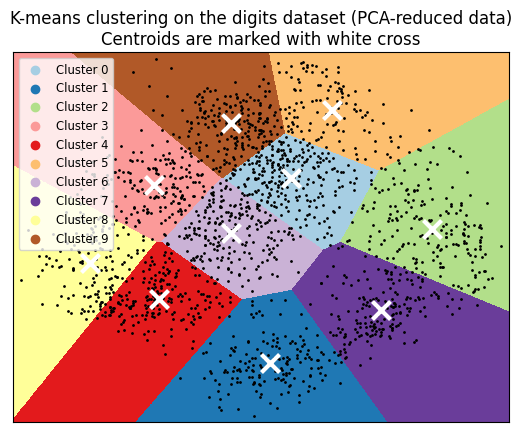

In [4]:
import matplotlib.pyplot as plt

# Giảm số chiều dữ liệu bằng PCA
reduced_data = PCA(n_components=2).fit_transform(data)

# Áp dụng KMeans
kmeans = KMeans(init="k-means++", n_clusters=n_digits, n_init=4)
kmeans.fit(reduced_data)

# Thiết lập kích thước ô lưới
h = 0.02

# Xác định phạm vi của lưới
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Dự đoán nhãn cho từng điểm trên lưới
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Vẽ đồ thị
plt.figure(1)
plt.clf()
plt.imshow(
    Z,
    interpolation="nearest",
    extent=(xx.min(), xx.max(), yy.min(), yy.max()),
    cmap=plt.cm.Paired,
    aspect="auto",
    origin="lower",
)

# Vẽ các điểm dữ liệu gốc
plt.plot(reduced_data[:, 0], reduced_data[:, 1], "k.", markersize=2)

# Vẽ các tâm cụm
centroids = kmeans.cluster_centers_
plt.scatter(
    centroids[:, 0],
    centroids[:, 1],
    marker="x",
    s=169,
    linewidths=3,
    color="w",
    zorder=10,
)

# Thiết lập tiêu đề và giới hạn trục
plt.title(
    "K-means clustering on the digits dataset (PCA-reduced data)\n"
    "Centroids are marked with white cross"
)
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())

# Hiển thị chú thích (legend) với nhãn cho từng cụm
colors = plt.cm.Paired(np.linspace(0, 1, n_digits))
for i in range(n_digits):
    plt.scatter([], [], color=colors[i], label=f'Cluster {i}')
plt.legend(scatterpoints=1, loc='best', shadow=False, fontsize='small')

plt.show()